# 📌 Status: Finalized

This notebook is finalized and runs end-to-end without manual intervention.

Purpose:
- Notebook 02: Synthetic data generation & pricing environment
- Notebook 03: Demand forecasting & forecast validation
- Notebook 04: Price optimization & revenue impact analysis

No further changes should be made to the logic below.


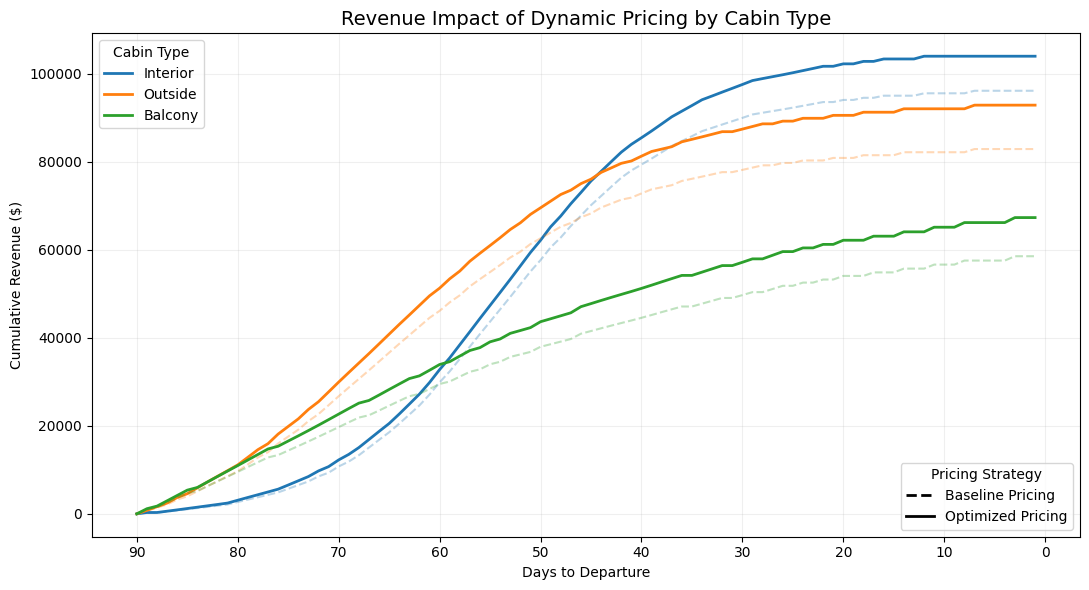

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load forecast output
df = pd.read_csv("../data/processed/cruise_pricing_with_forecast_clean.csv")
df["date"] = pd.to_datetime(df["date"])
df.head(10)

# ---- Calculation sort ----
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)

# ---- Daily expected units from forecast ----
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)

# 2) Convert cumulative % sold → cumulative units
df["forecast_cum_units"] = (
    (df["expected_pct_sold"] / 100) * df["total_inventory"]
).round().astype(int)

# 3) Derive DAILY bookings from cumulative units
df["forecast_daily_bookings"] = (
    df.groupby("cabin_type")["forecast_cum_units"]
      .diff()
      .fillna(df["forecast_cum_units"])
      .clip(lower=0)
      .astype(int)
)
# ---- Baseline daily revenue ----
df["baseline_daily_revenue"] = (
    df["forecast_daily_bookings"] * df["price"]
).round(2)

# ---- Elasticity by cabin ----
price_elasticity = {
    "Interior": -1.2,
    "Outside":  -1.0,
    "Balcony":  -0.8
}

def demand_response(units, price, base_price, e):
    return units * ((price / base_price) ** e)

price_multipliers = np.linspace(0.85, 1.15, 7)

# ---- Optimize today’s price for today’s expected demand ----
def optimize_row(row):
    base_price = row["price"]
    units = int(row["forecast_daily_bookings"])
    cap = int(row["remaining_inventory"])
    e = price_elasticity[row["cabin_type"]]

    if units <= 0 or cap <= 0:
        return base_price, 0.0

    best_price = base_price
    best_rev = units * base_price

    for m in price_multipliers:
        cand_price = round(base_price * m, 2)
        adj_units = demand_response(units, cand_price, base_price, e)
        adj_units = int(round(max(0, min(adj_units, cap))))
        rev = adj_units * cand_price
        if rev > best_rev:
            best_price, best_rev = cand_price, rev

    return best_price, round(best_rev, 2)

opt = df.apply(optimize_row, axis=1, result_type="expand")
df["optimal_price"] = opt[0]
df["optimized_daily_revenue"] = opt[1]

# ---- Uplift + cumulative (still calc-sorted) ----
df["daily_revenue_uplift"] = (
    df["optimized_daily_revenue"]
    - df["baseline_daily_revenue"]
).round(2)

df["baseline_cumulative_revenue"] = (
    df.groupby("cabin_type")["baseline_daily_revenue"].cumsum()
).round(2)

df["optimized_cumulative_revenue"] = (
    df.groupby("cabin_type")["optimized_daily_revenue"].cumsum()
).round(2)

# ---- Presentation sort ----
df = df.sort_values(["date", "cabin_type"]).reset_index(drop=True)

# ---- Plot ----
# Cabin colors
cabin_colors = {
    "Interior": "#1f77b4",
    "Outside":  "#ff7f0e",
    "Balcony":  "#2ca02c"
}

plt.figure(figsize=(11, 6))

for cabin, color in cabin_colors.items():
    sub = df[df["cabin_type"] == cabin] \
            .sort_values("days_to_departure", ascending=False)

    # Baseline (dashed)
    plt.plot(
        sub["days_to_departure"],
        sub["baseline_cumulative_revenue"],
        linestyle="--",
        linewidth=1.5,
        color=color,
        alpha=0.3
    )

    # Optimized (solid)
    plt.plot(
        sub["days_to_departure"],
        sub["optimized_cumulative_revenue"],
        linestyle="-",
        linewidth=2,
        color=color,
        label=cabin
    )

# Axis formatting
plt.gca().invert_xaxis()
plt.xlabel("Days to Departure")
plt.ylabel("Cumulative Revenue ($)")
plt.title("Revenue Impact of Dynamic Pricing by Cabin Type",fontsize=14)

# Legend 
# First legend: cabin types (colors)
cabin_legend = plt.legend(
    title="Cabin Type",
    loc="upper left"
)
plt.gca().add_artist(cabin_legend)
from matplotlib.lines import Line2D

style_legend = [
    Line2D([0], [0], color="black", linestyle="--", linewidth=2,
           label="Baseline Pricing"),
    Line2D([0], [0], color="black", linestyle="-", linewidth=2,
           label="Optimized Pricing")
]

plt.legend(
    handles=style_legend,
    title="Pricing Strategy",
    loc="lower right"
)

# Grid
plt.grid(alpha=0.2)

#Ticks
ticks = list(range(
    int(df["days_to_departure"].max()),
    -1,
    -10
))
plt.xticks(ticks)
plt.tight_layout()
plt.savefig(
    "../figures/04_Revenue_days_to_departure.png",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [9]:
rename_map = {
    "price": "base_price",
    "optimal_price": "optimized_price",

    "forecast_daily_bookings": "forecast_daily_bookings",

    "baseline_daily_revenue": "baseline_daily_revenue",
    "optimized_daily_revenue": "optimized_daily_revenue",

    "daily_revenue_uplift": "daily_revenue_uplift",

    "baseline_cumulative_revenue": "baseline_cumulative_revenue",
    "optimized_cumulative_revenue": "optimized_cumulative_revenue",

    "expected_pct_sold": "forecast_cumulative_pct_sold",
    "expected_daily_pct": "forecast_daily_pct_sold"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

ordered_cols = [

    # 🧭 Time & product
    "date",
    "days_to_departure",
    "cabin_type",

    # 📈 Demand (comparison)
    "bookings", # actual
    "forecast_daily_bookings",      # expected

    # 💰 Prices (comparison)
    "base_price",
    "optimized_price",
    "pct_sold",
    "forecast_cumulative_pct_sold",

    # 💵 Daily revenue (comparison)
    "baseline_daily_revenue",
    "optimized_daily_revenue",
    "daily_revenue_uplift",

    # 📊 Cumulative revenue (comparison)
    "baseline_cumulative_revenue",
    "optimized_cumulative_revenue"
]
df_final = df[[c for c in ordered_cols if c in df.columns]].copy()

In [10]:
df_final.head(10)

,date,days_to_departure,cabin_type,bookings,forecast_daily_bookings,base_price,optimized_price,pct_sold,forecast_cumulative_pct_sold,baseline_daily_revenue,optimized_daily_revenue,daily_revenue_uplift,baseline_cumulative_revenue,optimized_cumulative_revenue
0,2025-10-21,90,Balcony,0,0,525.0,525.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
1,2025-10-21,90,Interior,2,0,263.0,263.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
2,2025-10-21,90,Outside,8,0,351.0,351.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
3,2025-10-22,89,Balcony,2,2,507.0,583.05,0.0,1.68,1014.0,1166.10,152.10,1014.0,1166.10
4,2025-10-22,89,Interior,10,1,265.0,304.75,0.7,0.19,265.0,304.75,39.75,265.0,304.75
5,2025-10-22,89,Outside,1,2,351.0,403.65,4.0,0.97,702.0,807.30,105.30,702.0,807.30
6,2025-10-23,88,Balcony,1,1,509.0,585.35,2.0,3.38,509.0,585.35,76.35,1523.0,1751.45
7,2025-10-23,88,Interior,4,0,264.0,264.00,4.0,0.40,0.0,0.00,0.00,265.0,304.75
8,2025-10-23,88,Outside,3,2,356.0,409.40,4.5,2.00,712.0,818.80,106.80,1414.0,1626.10
9,2025-10-24,87,Balcony,2,2,525.0,603.75,3.0,5.12,1050.0,1207.50,157.50,2573.0,2958.95


In [11]:
# ---- Export ----
df_final.to_csv("../data/processed/cruise_pricing_with_optimization_full.csv", index=False)
print("Optimization export ready:", df.shape)

Optimization export ready: (270, 22)
